# RT Correlation

In this notebook I explore the correlation that might exist between CCS and RT

## Preliminars

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import utils
import scipy
import sklearn as sk

In [2]:
%load_ext autoreload
%autoreload 2

In [4]:
df1 = pd.read_csv('../dl_paper/SourceData_Figure_1.csv')
df4 = pd.read_csv('../dl_paper/SourceData_Figure_4.csv')

## Exploration

Makes sense to expect a correlation of RT and CCS? 

Text(0.5, 1.0, 'CCS vs RT < 120, keeps 87.0% of all points')

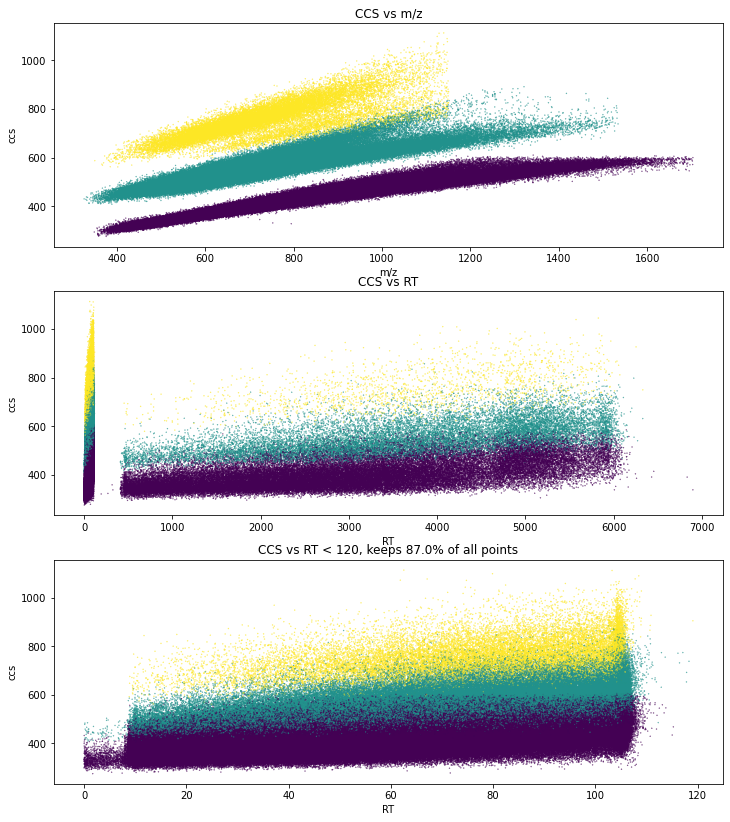

In [7]:
fig, ax = plt.subplots(nrows = 3, ncols = 1, figsize = (12,14))
ax[0].scatter(df1['m/z'], df1['CCS'], c = df1['Charge'], s = 0.1)
ax[0].set_xlabel('m/z')
ax[0].set_ylabel('ccs')
ax[0].set_title('CCS vs m/z')

ax[1].scatter(df1['Retention time'], df1['CCS'], c = df1['Charge'], s = 0.1)
ax[1].set_xlabel('RT')
ax[1].set_ylabel('ccs')
ax[1].set_title('CCS vs RT')

thr = 120
mask = df1['Retention time'] < thr
ax[2].scatter(df1['Retention time'][mask], df1['CCS'][mask], c = df1['Charge'][mask], s = 0.1)
ax[2].set_xlabel('RT')
ax[2].set_ylabel('ccs')
ax[2].set_title(f'CCS vs RT < {thr}, keeps {np.round(len(df1[mask])/len(df1), 2)*100}% of all points')


Looks like they're correlated, also for simplicty let's just focus on RT < 120



In [19]:
from regression_linear import LinearRegression

In [30]:
%matplotlib inline

In [21]:
df1_rt120 = df1[df1['Retention time'] < 120]

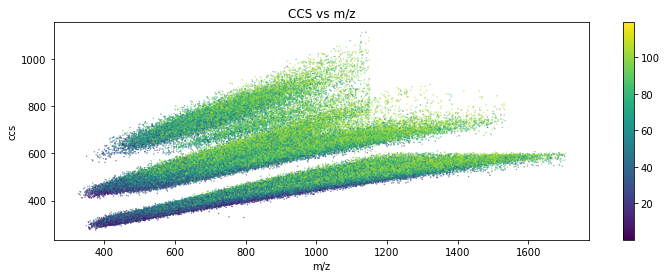

In [30]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (12,4))
sp = ax.scatter(df1_rt120['m/z'], df1_rt120['CCS'], c = df1_rt120['Retention time'], s = 0.1)
ax.set_xlabel('m/z')
ax.set_ylabel('ccs')
ax.set_title('CCS vs m/z')
plt.colorbar(sp)

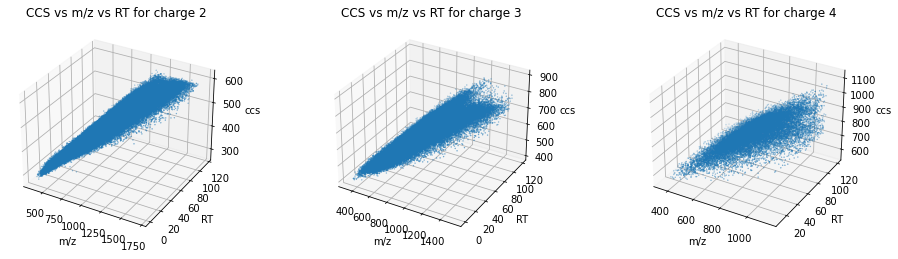

In [32]:
fig = plt.figure(figsize = (16, 4))
for i in range(3):
    ax = fig.add_subplot(int(f'13{i+1}'), projection = '3d')
    charge = i+2
    mask = df1_rt120['Charge'] == charge
    ax.scatter(df1_rt120['m/z'][mask], df1_rt120['Retention time'][mask], df1_rt120['CCS'][mask], s = 0.1)
    ax.set_xlabel('m/z')
    ax.set_ylabel('RT')
    ax.set_zlabel('ccs')
    ax.set_title(f'CCS vs m/z vs RT for charge {charge}')

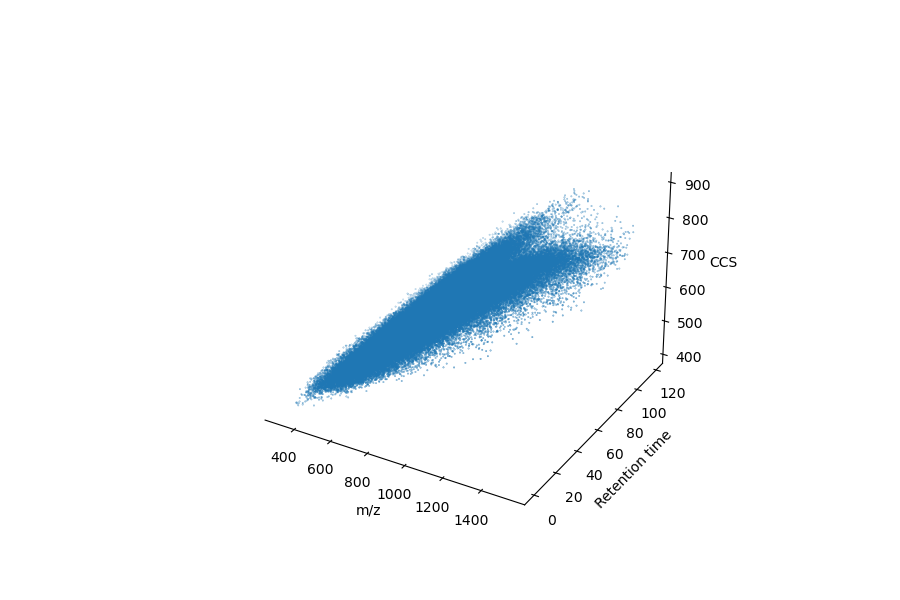

In [28]:
fig = plt.figure(figsize = (9,6))
ax = plt.subplot(111, projection = "3d")

# Remove gray panes and axis grid
ax.xaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor('white')
ax.set_xlabel('m/z')
ax.yaxis.pane.fill = False
ax.yaxis.pane.set_edgecolor('white')
ax.set_ylabel('Retention time')
ax.zaxis.pane.fill = False
ax.zaxis.pane.set_edgecolor('white')
ax.set_zlabel('CCS')
ax.grid(False)

# Remove z-axis

mask = df1_rt120['Charge'] == 3
# Plot surface
plot = ax.scatter(df1_rt120['m/z'][mask], df1_rt120['Retention time'][mask], df1_rt120['CCS'][mask], cmap='YlGnBu_r', vmin=0, vmax=200, s = 0.1)

There is only one population, the second one disapeared.


## Correlation of residual of linear regression with RT

At last, let's see if the residual after fiting a linear model to the data is correlated to the RT

In [18]:
df_ch2 = df1_rt120[df1_rt120['Charge']==2]
df_ch3 = df1_rt120[df1_rt120['Charge']==3]
df_ch4 = df1_rt120[df1_rt120['Charge']==4]

f = lambda x, A, b: A*x**b 

popt_2, _ =scipy.optimize.curve_fit(f, df_ch2['m/z'], df_ch2['CCS'])
popt_3, _ =scipy.optimize.curve_fit(f, df_ch3['m/z'], df_ch3['CCS'])
popt_4, _ =scipy.optimize.curve_fit(f, df_ch4['m/z'], df_ch4['CCS'])

df1_rt120['predicted_ccs'] = 0

df1_rt120.loc[df1_rt120['Charge']==2,'predicted_ccs'] = f(df_ch2['m/z'], popt_2[0], popt_2[1])
df1_rt120.loc[df1_rt120['Charge']==3,'predicted_ccs'] = f(df_ch3['m/z'], popt_3[0], popt_3[1])
df1_rt120.loc[df1_rt120['Charge']==4,'predicted_ccs'] = f(df_ch4['m/z'], popt_4[0], popt_4[1])

/fs/home/rlopez/miniconda3/envs/ccs/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/fs/home/rlopez/miniconda3/envs/ccs/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


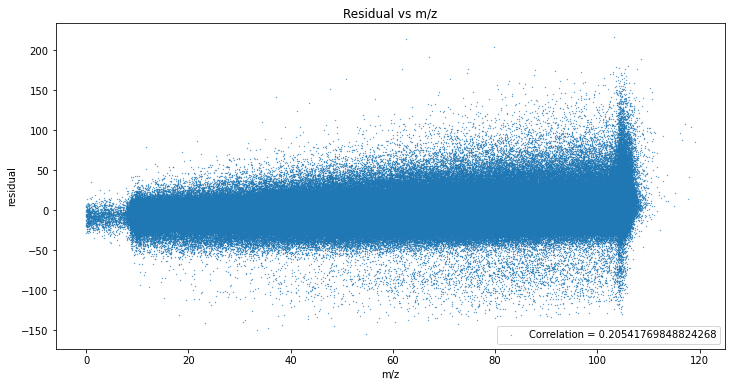

In [ ]:
fig = plt.gcf()
fig.set_size_inches((12,6))
mask = df1_rt120['Retention time'] < 150
residual = df1_rt120['CCS'][mask] -  df1_rt120['predicted_ccs'][mask]
corr, _ = scipy.stats.pearsonr(df1_rt120['Retention time'][mask], residual)
plt.scatter(df1_rt120['Retention time'][mask], residual, s = 0.1, label = f'Correlation = {corr}')
plt.xlabel('m/z')
plt.ylabel('residual')
plt.title('Residual vs RT')
plt.legend(loc='lower right')

The residual is correalted, for sure the RT will have an important impact on RT prediction

## Add Retention Time To Test Set 

To see if the correlation really improves the predictions we need to add RT to the test set, we have to load in comvined_sm where the whole preprocessed dataset is saved and find the interception with figure 4 df. Then we create a new df called test_df with the complete information of the test set

In [4]:
path_combined = '/fs/pool/pool-cox-data08/Juan/ccs/Data/github/combined_sm.csv'
df_combined = pd.read_csv(path_combined, sep=',')
df_combined_midx = df_combined.set_index(['Modified sequence', 'Charge'])

In [5]:
df4_midx = df4.set_index(['Modified_sequence', 'Charge'])

In [11]:
interception = df_combined_midx.loc[df4_midx.index]
interception_reindex = interception.set_index(np.arange(interception.shape[0]))
test_df = interception_reindex.drop('Unnamed: 0', axis = 1)
test_df['Modified sequence'] = interception.index.get_level_values(0).to_numpy()
test_df['Charge'] = interception.index.get_level_values(1).to_numpy()

In [13]:
test_df['m/z'] = test_df.apply(lambda x: utils.calculate_mass(x['Modified sequence'], x['Charge']), axis = 1)

In [15]:
test_df.to_pickle('/fs/pool/pool-cox-data08/Juan/ccs/Data/Fig4_with_RT.pkl')

# Regression Models

Now that we have the data we will see how the calculation changes when adding RT information

## Multilinear Regression

In [17]:
import regression_bilinear

In [18]:
test_df = pd.read_pickle('/fs/pool/pool-cox-data08/Juan/ccs/Data/Fig4_with_RT.pkl')
test_df_rt120 = test_df[test_df['Retention time'] < 120]

In [19]:
br = regression_bilinear.BilinearRegression()
br.fit(df1_rt120)

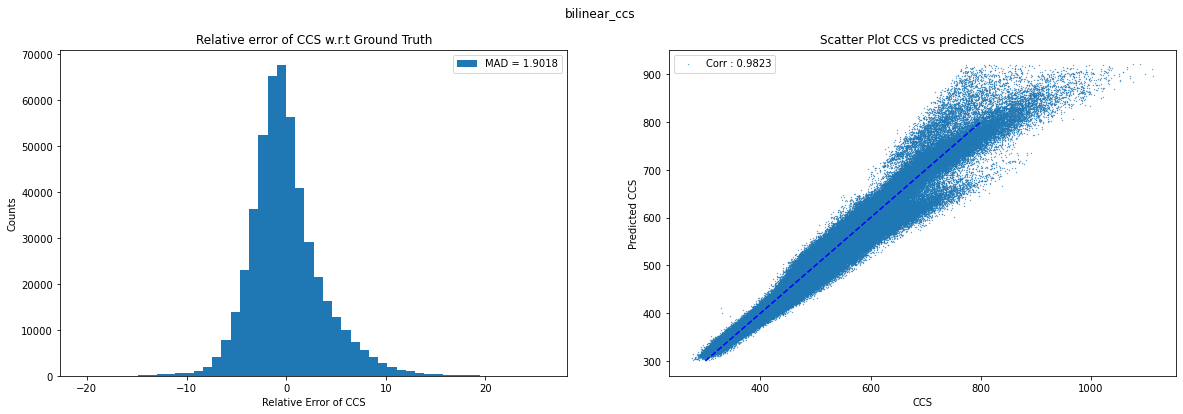

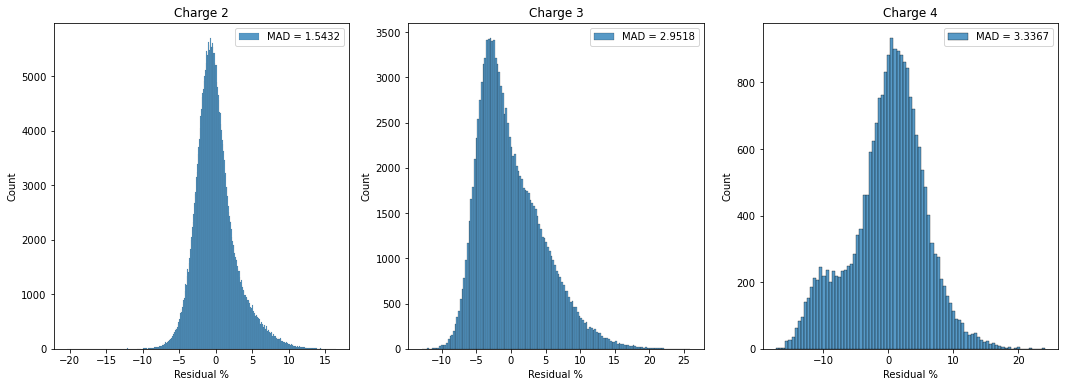

In [20]:
br.test_set_plot(df1_rt120)

Text(0.5, 1.0, 'CCS vs m/z')

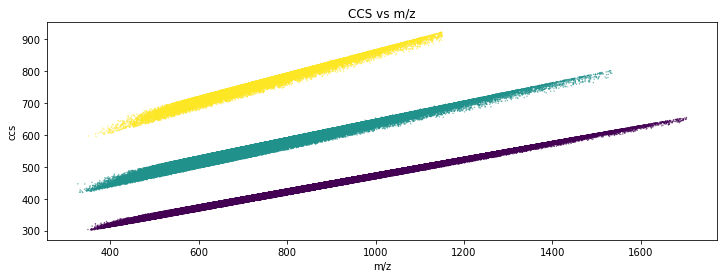

In [23]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (12,4))
sp = ax.scatter(df1_rt120['m/z'], df1_rt120['bilinear_ccs'], c = df1_rt120['Charge'], s = 0.1)
ax.set_xlabel('m/z')
ax.set_ylabel('ccs')
ax.set_title('CCS vs m/z')


## SVR

In [52]:
import svr

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [49]:
regr2 = svr.train(2, 'Di-peptides', save = True, n_estimators = 50, n_jobs=50, add_rt=True)
regr3 = svr.train(3, 'Di-peptides', save = True, n_estimators = 50, n_jobs=50, add_rt=True)
regr4 = svr.train(4, 'Di-peptides', save = True, n_estimators = 50, n_jobs=50, add_rt=True)

/fs/pool/pool-cox-data08/Juan/ccs/Data/dipeptide_fig1.npy True
Take specific charge state
Subsample
(340576, 678) (340576,)
Starting Training


[Parallel(n_jobs=50)]: Using backend LokyBackend with 50 concurrent workers.
[Parallel(n_jobs=50)]: Done   2 out of  50 | elapsed:   34.8s remaining: 13.9min
[Parallel(n_jobs=50)]: Done  50 out of  50 | elapsed:   51.1s finished


51.17362999916077
/fs/pool/pool-cox-data08/Juan/ccs/Data/dipeptide_fig1.npy True
Take specific charge state
Subsample
(125803, 678) (125803,)
Starting Training


[Parallel(n_jobs=50)]: Using backend LokyBackend with 50 concurrent workers.
[Parallel(n_jobs=50)]: Done   2 out of  50 | elapsed:    8.2s remaining:  3.3min
[Parallel(n_jobs=50)]: Done  50 out of  50 | elapsed:   13.4s finished


13.471698999404907
/fs/pool/pool-cox-data08/Juan/ccs/Data/dipeptide_fig1.npy True
Take specific charge state
Subsample
(22574, 678) (22574,)
Starting Training


[Parallel(n_jobs=50)]: Using backend LokyBackend with 50 concurrent workers.
[Parallel(n_jobs=50)]: Done   2 out of  50 | elapsed:    1.2s remaining:   27.7s


2.3842766284942627


[Parallel(n_jobs=50)]: Done  50 out of  50 | elapsed:    2.3s finished


In [1]:
svr_dip = svr.test_set_results('Di-peptides', add_rt = True)

NameError: name 'svr' is not defined

In [56]:
aux = pd.read_pickle('/fs/pool/pool-cox-data08/Juan/ccs/Data/Fig4_with_RT.pkl')
aux['predicted_ccs'] = df4['label Prediction 0'].values

In [57]:
aux.to_pickle('/fs/pool/pool-cox-data08/Juan/ccs/Data/Fig4_with_RT.pkl')